### Plot the altimeters from the Bar and Trough sites

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

pathn = r"C:\\crs\\proj\\2019_DUNEX\\Pea_Island_Data\\01_Nearshore\\"
barfn = "aa400_0074_orange_raw_trim.txt"
troughfn = "aa400_0074_purple_raw_trim.txt"

# number of samples in each burst
burstn = 10

#### Read the file into memory and strip leading white space

In [3]:
with open(pathn+barfn) as file:
    lines = file.readlines()

# Strip leading white space. Note we are skipping first line, which has column titles
lines = [line.rstrip() for line in lines][1:]

#### Parse the lines. Dates and times will be in lists; values will be in arrays

In [4]:
dates = [line.split()[0] for line in lines]
times = [line.split()[1] for line in lines]
alts =  np.asarray([line.split()[3] for line in lines], dtype=np.float32)
temps = np.asarray([line.split()[4] for line in lines], dtype=np.float32)
batts = np.asarray([line.split()[5] for line in lines], dtype=np.float32)
amps =  np.asarray([line.split()[6] for line in lines], dtype=np.float32)

#### Reshape the arrays to 2D array with [number of bursts, burstn], then calculate selected statistics for each burst

In [5]:
altmax = np.max( np.reshape(alts,(len(times)//burstn,burstn)), 1 )
altstd = np.std( np.reshape(alts,(len(times)//burstn,burstn)), 1 )
ampmax = np.max( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
ampmn = np.mean( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
ampstd = np.std( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
temps = np.mean( np.reshape(temps,(len(times)//burstn,burstn)), 1 )

#### Create an array of datetime objects  and select the start time of each burst
There should be a way to do this without using append

In [6]:
dt = []
for s in zip(dates, times):
    dt.append( datetime.datetime.strptime( s[0]+' '+s[1], '%Y%m%d %H:%M:%S.%f') )    

# dts is the array of start times
dts = np.reshape(dt,(len(times)//burstn,burstn))[:,1]

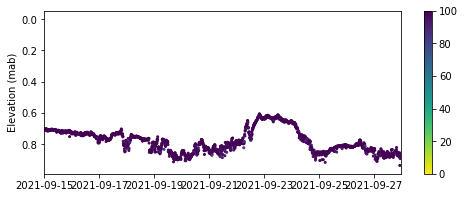

In [7]:
fig, ax = plt.subplots(figsize = (8,3))
plt.scatter(dts,altmax/1000,s=4,c=ampmn,cmap='viridis_r')
plt.gca().invert_yaxis()
ax.set_xlim([datetime.date(2021, 9, 15), datetime.date(2021, 9, 28)])
#ax.set_ylim([0, 1])
plt.ylabel('Elevation (mab)')
plt.colorbar()

In [8]:
col_names = ['Date','Time', 'Ping', 'Altitude','Temperature','Battery','Amplitude']
#, 'Ampl','Median','Average Value','NSeries','Interval'] 
dfb = pd.read_csv(pathn+barfn, names=col_names,delim_whitespace=True)
dfb

Date  Time  \
Date     Time         Ping  Altitude Temperature Battery  Amplitude  Ampl   
20210913 10:00:00.000 60    0.0      21.97       4518             0   0.0   
         10:00:01.000 61    0.0      21.97       4518             0   0.0   
         10:00:02.000 62    0.0      21.97       4518             0   0.0   
         10:00:03.000 63    0.0      21.97       4518             0   0.0   
...                                                             ...   ...   
20211019 17:50:05.000 52375 0.0      19.93       4356             0   0.0   
         17:50:06.000 52376 0.0      19.93       4356             0   0.0   
         17:50:07.000 52377 0.0      19.93       4356             0   0.0   
         17:50:08.000 52378 0.0      19.93       4356             0   0.0   
         17:50:09.000 52379 0.0      19.93       4356             0   0.0   

                                                              Ping Altitude  \
Date     Time         Ping  Altitude Temperature Battery  Median15  Average   
20210913 10:00:00.000 60    0.0      21.97       4518          0.0      0.0   
         10:00:01.000 61    0.0      21.97       4518          0.0      0.0   
         10:00:02.000 62    0.0      21.97       4518          0.0      0.0   
         10:00:03.000 63    0.0      21.97       4518          0.0      0.0   
...                                                            ...      ...   
20211019 17:50:05.000 52375 0.0      19.93       4356        835.4    835.4   
         17:50:06.000 52376 0.0      19.93       4356        835.4    835.4   
         17:50:07.000 52377 0.0      19.93       4356        835.4    835.4   
         17:50:08.000 52378 0.0      19.93       4356        835.4    835.4   
         17:50:09.000 52379 0.0      19.93       4356        835.4    835.4   

                                                         Temperature  Battery  \
Date     Time         Ping  Altitude Temperature Battery       Value  NSeries   
20210913 10:00:00.000 60    0.0      21.97       4518            NaN      NaN   
         10:00:01.000 61    0.0      21.97       4518            NaN      NaN   
         10:00:02.000 62    0.0      21.97       4518            NaN      NaN   
         10:00:03.000 63    0.0      21.97       4518            NaN      NaN   
...                                                              ...      ...   
20211019 17:50:05.000 52375 0.0      19.93       4356            NaN      NaN   
         17:50:06.000 52376 0.0      19.93       4356            NaN      NaN   
         17:50:07.000 52377 0.0      19.93       4356            NaN      NaN   
         17:50:08.000 52378 0.0      19.93       4356            NaN      NaN   
         17:50:09.000 52379 0.0      19.93       4356         835.40     N:10   

                                                          Amplitude  
Date     Time         Ping  Altitude Temperature Battery   Interval  
20210913 10:00:00.000 60    0.0      21.97       4518           NaN  
         10:00:01.000 61    0.0      21.97       4518           NaN  
         10:00:02.000 62    0.0      21.97       4518           NaN  
         10:00:03.000 63    0.0      21.97       4518           NaN  
...                                                             ...  
20211019 17:50:05.000 52375 0.0      19.93       4356           NaN  
         17:50:06.000 52376 0.0      19.93       4356           NaN  
         17:50:07.000 52377 0.0      19.93       4356           NaN  
         17:50:08.000 52378 0.0      19.93       4356           NaN  
         17:50:09.000 52379 0.0      19.93       4356     Interval:  

[52321 rows x 7 columns]